# 查看FashionMNIST原始数据格式

In [18]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from wangdao_deeplearning_train import EarlyStopping, ModelSaver,train_classification_model,plot_learning_curves
from wangdao_deeplearning_train import evaluate_classification_model as evaluate_model

# 加载数据并处理为tensor

In [19]:
from pathlib import Path

DATA_DIR = Path("./archive/")

# 定义数据预处理
data_transforms = {
    'training': transforms.Compose([
        transforms.Resize((128, 128)),  # 调整图像大小为128x128
        transforms.ToTensor(),  # 将图像转换为Tensor
        transforms.Normalize(mean=[0.4363, 0.4328, 0.3291], std=[0.2085, 0.2032, 0.1988])  # 标准化，使用ImageNet的均值和标准差
    ]),
    'validation': transforms.Compose([
        transforms.Resize((128, 128)),  # 调整图像大小为128x128
        transforms.ToTensor(),  # 将图像转换为Tensor
        transforms.Normalize(mean=[0.4363, 0.4328, 0.3291], std=[0.2085, 0.2032, 0.1988])  # 标准化，使用ImageNet的均值和标准差
    ]),
}

# 使用ImageFolder加载数据
# ImageFolder假设数据集按照如下方式组织：root/class/image.jpg
train_dataset = datasets.ImageFolder(
    root=DATA_DIR / 'training',
    transform=data_transforms['training']
)

test_dataset = datasets.ImageFolder(
    root=DATA_DIR / 'validation',
    transform=data_transforms['validation']
)

# 打印类别信息
class_names = train_dataset.classes
print(f"类别数量: {len(class_names)}")
print(f"类别名称: {class_names}")

# 查看一个样本
img, label = train_dataset[0]
print(f"图像形状: {img.shape}")  # 应该是[3, 128, 128]
print(f"标签: {label} (类别: {class_names[label]})")


类别数量: 10
类别名称: ['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']
图像形状: torch.Size([3, 128, 128])
标签: 0 (类别: n0)


In [20]:
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds: #img是图像，_是标签
        mean += img.mean(dim=(1, 2)) #dim=(1, 2)表示在通道维度上求平均
        std += img.std(dim=(1, 2))  #dim=(1, 2)表示在通道维度上求标准差
    mean /= len(ds)
    std /= len(ds)
    return mean, std
# cal_mean_std(train_dataset)

# 把数据集划分为训练集55000和验证集5000，并给DataLoader

In [21]:


# 创建数据加载器
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True #打乱数据集，每次迭代时，数据集的顺序都会被打乱
)

val_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# 打印数据集大小信息
print(f"训练集大小: {len(train_dataset)}")
print(f"测试集大小: {len(test_dataset)}")
print(f"批次大小: {batch_size}")
print(f"训练批次数: {len(train_loader)}")


训练集大小: 1097
测试集大小: 272
批次大小: 32
训练批次数: 35


In [22]:
64*860

55040

# 搭建模型

In [23]:

#理解每个接口的方法，单独写例子
import torch.nn as nn
m=nn.BatchNorm1d(100) # 创建一个批量归一化层，输入特征维度为100
x=torch.randn(20,100) # 创建一个20行100列的随机张量
print(m(x).shape) # 打印批量归一化后的张量形状

torch.Size([20, 100])


# 解析padding超参

In [24]:
# 初始化一个5*5的卷积层，保持输入输出图像尺寸不变
# 要保持尺寸不变，需要设置适当的padding
# 对于kernel_size=5的卷积，需要padding=2才能保持尺寸不变

import torch
import torch.nn as nn

# 创建一个卷积层，输入通道为1，输出通道为16，卷积核大小为5x5，padding为2,步长为2
conv = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2,stride=2)

# 创建卷积层
# padding='same' 表示使用动态padding，保持输入输出图像尺寸不变,为same时，步长只能为1
# padding='valid' 表示不使用padding，输出图像尺寸会变小

# 创建一个随机输入张量，模拟一个批次的单通道图像，比如28x28的MNIST图像
input_tensor = torch.randn(1, 1, 28, 28)  # [批次大小, 通道数, 高度, 宽度]

# 进行卷积操作
output = conv(input_tensor)

# 打印输入和输出的形状，验证尺寸是否保持不变
print(f"输入张量形状: {input_tensor.shape}")
print(f"输出张量形状: {output.shape}")
print(f"卷积层参数: kernel_size={conv.kernel_size}, padding={conv.padding}, stride={conv.stride}")


输入张量形状: torch.Size([1, 1, 28, 28])
输出张量形状: torch.Size([1, 16, 14, 14])
卷积层参数: kernel_size=(5, 5), padding=(2, 2), stride=(2, 2)


In [25]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        # 第一组卷积层 - 32个卷积核
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # 输入通道数，输出通道数代表的是卷积核的个数
        
        # 深度可分离卷积替代conv2
        self.depthwise2 = nn.Conv2d(32, 32, kernel_size=3, padding=1, groups=32)
        self.pointwise2 = nn.Conv2d(32, 32, kernel_size=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # 第二组卷积层 - 64个卷积核
        # 深度可分离卷积替代conv3
        self.depthwise3 = nn.Conv2d(32, 32, kernel_size=3, padding=1, groups=32)
        self.pointwise3 = nn.Conv2d(32, 64, kernel_size=1)
        
        # 深度可分离卷积替代conv4
        self.depthwise4 = nn.Conv2d(64, 64, kernel_size=3, padding=1, groups=64)
        self.pointwise4 = nn.Conv2d(64, 64, kernel_size=1)

        # 第三组卷积层 - 128个卷积核
        # 深度可分离卷积替代conv5
        self.depthwise5 = nn.Conv2d(64, 64, kernel_size=3, padding=1, groups=64)
        self.pointwise5 = nn.Conv2d(64, 128, kernel_size=1)
        
        # 深度可分离卷积替代conv6
        self.depthwise6 = nn.Conv2d(128, 128, kernel_size=3, padding=1, groups=128)
        self.pointwise6 = nn.Conv2d(128, 128, kernel_size=1)

        # 计算全连接层的输入特征数
        # 经过3次池化，图像尺寸从28x28变为3x3x128
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 10)

        # 初始化权重
        self.init_weights()

    def init_weights(self):
        """使用 xavier 均匀分布来初始化卷积层和全连接层的权重"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        # x.shape [batch size, 1, 28, 28]

        # 第一组卷积层
        x = F.selu(self.conv1(x))
        # print(f"conv1后的形状: {x.shape}")
        
        # 深度可分离卷积替代conv2
        x = F.selu(self.depthwise2(x))
        x = F.selu(self.pointwise2(x))
        # print(f"conv2后的形状: {x.shape}")
        
        x = self.pool(x)
        # print(f"pool1后的形状: {x.shape}")

        # 第二组卷积层
        # 深度可分离卷积替代conv3
        x = F.selu(self.depthwise3(x))
        x = F.selu(self.pointwise3(x))
        # print(f"conv3后的形状: {x.shape}")
        
        # 深度可分离卷积替代conv4
        x = F.selu(self.depthwise4(x))
        x = F.selu(self.pointwise4(x))
        # print(f"conv4后的形状: {x.shape}")
        
        x = self.pool(x)
        # print(f"pool2后的形状: {x.shape}")

        # 第三组卷积层
        # 深度可分离卷积替代conv5
        x = F.selu(self.depthwise5(x))
        x = F.selu(self.pointwise5(x))
        # print(f"conv5后的形状: {x.shape}")
        
        # 深度可分离卷积替代conv6
        x = F.selu(self.depthwise6(x))
        x = F.selu(self.pointwise6(x))
        # print(f"conv6后的形状: {x.shape}")
        
        x = self.pool(x)
        # print(f"pool3后的形状: {x.shape}")

        # 展平
        x = x.view(x.size(0), -1)
        # print(f"展平后的形状: {x.shape}")

        # 全连接层
        x = F.selu(self.fc1(x))
        # print(f"fc1后的形状: {x.shape}")
        x = self.fc2(x)
        # print(f"fc2后的形状: {x.shape}")

        return x

In [26]:
# 实例化模型
model = NeuralNetwork()

# 从train_loader获取第一个批次的数据
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 查看批次数据的形状
print("批次图像形状:", images.shape)
print("批次标签形状:", labels.shape)


print('-'*100)
# 进行前向传播
with torch.no_grad():  # 不需要计算梯度
    outputs = model(images)


print(outputs.shape)

批次图像形状: torch.Size([32, 3, 128, 128])
批次标签形状: torch.Size([32])
----------------------------------------------------------------------------------------------------
torch.Size([32, 10])


In [27]:
# 计算模型的总参数量
# 统计需要求梯度的参数总量
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"需要求梯度的参数总量: {total_params}")

# 统计所有参数总量
all_params = sum(p.numel() for p in model.parameters())
print(f"模型总参数量: {all_params}")

# 查看每层参数量明细
print("\n各层参数量明细:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()} 参数")

需要求梯度的参数总量: 8427690
模型总参数量: 8427690

各层参数量明细:
conv1.weight: 864 参数
conv1.bias: 32 参数
depthwise2.weight: 288 参数
depthwise2.bias: 32 参数
pointwise2.weight: 1024 参数
pointwise2.bias: 32 参数
depthwise3.weight: 288 参数
depthwise3.bias: 32 参数
pointwise3.weight: 2048 参数
pointwise3.bias: 64 参数
depthwise4.weight: 576 参数
depthwise4.bias: 64 参数
pointwise4.weight: 4096 参数
pointwise4.bias: 64 参数
depthwise5.weight: 576 参数
depthwise5.bias: 64 参数
pointwise5.weight: 8192 参数
pointwise5.bias: 128 参数
depthwise6.weight: 1152 参数
depthwise6.bias: 128 参数
pointwise6.weight: 16384 参数
pointwise6.bias: 128 参数
fc1.weight: 8388608 参数
fc1.bias: 256 参数
fc2.weight: 2560 参数
fc2.bias: 10 参数


In [28]:
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 0.0148, -0.0121, -0.0785],
                        [-0.1066,  0.0991,  0.1099],
                        [ 0.0526,  0.1040, -0.0199]],
              
                       [[ 0.0192,  0.0014,  0.0246],
                        [-0.0327,  0.0501,  0.1259],
                        [-0.1378,  0.1211, -0.1070]],
              
                       [[ 0.0930, -0.1055,  0.0265],
                        [ 0.1271,  0.0305, -0.0992],
                        [-0.0628,  0.1375, -0.1273]]],
              
              
                      [[[-0.0910, -0.0856,  0.0212],
                        [ 0.0606, -0.0617, -0.1286],
                        [-0.0413,  0.0610, -0.0896]],
              
                       [[ 0.0860,  0.0400, -0.1134],
                        [ 0.0408, -0.0911,  0.1340],
                        [-0.1032, -0.0370,  0.1290]],
              
                       [[-0.0517,  0.1105,  0.0273],
                        [ 

# 设置交叉熵损失函数，SGD优化器

In [29]:
model = NeuralNetwork()
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()  # 交叉熵损失函数，适用于多分类问题，里边会做softmax，还有会把0-9标签转换成one-hot编码

print("损失函数:", loss_fn)


损失函数: CrossEntropyLoss()


In [30]:
model = NeuralNetwork()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # SGD优化器，学习率为0.01，动量为0.9

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")
model = model.to(device) #将模型移动到GPU
early_stopping=EarlyStopping(patience=10, delta=0.001)
model_saver=ModelSaver(save_dir='model_weights', save_best_only=True)


model, history = train_classification_model(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=50,early_stopping=early_stopping, model_saver=model_saver, tensorboard_logger=None,eval_step=50)


使用设备: cpu
训练开始，共1750步


  0%|          | 0/1750 [00:00<?, ?it/s]

In [32]:
history['train'][-100:-1]

[{'loss': 0.022269777953624725, 'acc': 100.0, 'step': 1650},
 {'loss': 0.02467423304915428, 'acc': 100.0, 'step': 1651},
 {'loss': 0.021855875849723816, 'acc': 100.0, 'step': 1652},
 {'loss': 0.050618790090084076, 'acc': 100.0, 'step': 1653},
 {'loss': 0.025835590437054634, 'acc': 100.0, 'step': 1654},
 {'loss': 0.021344678476452827, 'acc': 100.0, 'step': 1655},
 {'loss': 0.026316970586776733, 'acc': 100.0, 'step': 1656},
 {'loss': 0.027194086462259293, 'acc': 100.0, 'step': 1657},
 {'loss': 0.03417690470814705, 'acc': 100.0, 'step': 1658},
 {'loss': 0.01839793659746647, 'acc': 100.0, 'step': 1659},
 {'loss': 0.02576238289475441, 'acc': 100.0, 'step': 1660},
 {'loss': 0.03341296687722206, 'acc': 100.0, 'step': 1661},
 {'loss': 0.02654407173395157, 'acc': 100.0, 'step': 1662},
 {'loss': 0.05189359933137894, 'acc': 100.0, 'step': 1663},
 {'loss': 0.03281692788004875, 'acc': 100.0, 'step': 1664},
 {'loss': 0.03028850629925728, 'acc': 100.0, 'step': 1665},
 {'loss': 0.03493152931332588, 'a

# 绘制损失曲线和准确率曲线

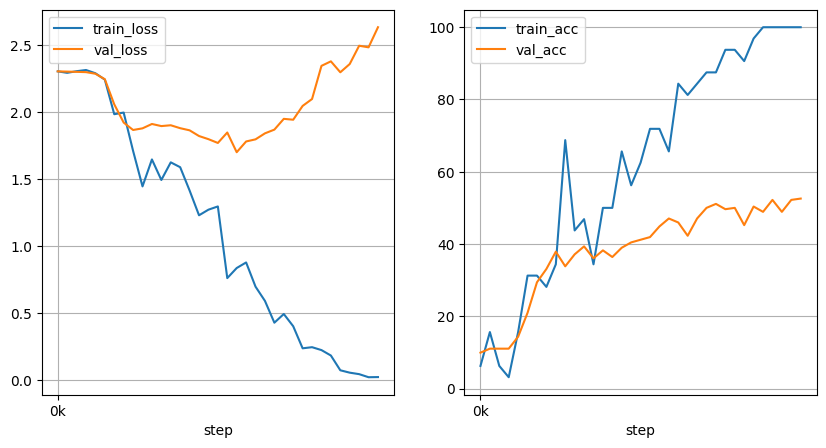

In [33]:
plot_learning_curves(history, sample_step=50)  #横坐标是 steps

In [34]:
# 在测试集上评估模型
test_accuracy = evaluate_model(model, test_loader, device, loss_fn)
test_accuracy


(52.5735294117647, 2.559074177461512)